# EPH School Dropouts

The [Encuesta Permanente de Hogares (EPH)](https://www.indec.gob.ar/indec/web/Institucional-Indec-BasesDeDatos), or Permanent Household Survey, is a continuous and periodic survey conducted by the [Instituto Nacional de Estadística y Censos (INDEC) of Argentina](https://www.indec.gob.ar). The EPH provides information on the social, economic, and demographic characteristics of households and individuals in Argentina. The survey is conducted on a quarterly basis in a sample of approximately 30,000 households located throughout the country.

The EPH collects data on a wide range of topics, including:

* Household characteristics: size, composition, tenure, and access to basic services
* Individual characteristics: age, sex, education, marital status, employment status, and income
* Income and expenditure: household income, individual income, and household expenditure
* Access to health services: health insurance, use of preventive services, and satisfaction with health care
* Access to education: enrollment in schooling, attendance rates, and educational attainment
* Housing conditions: type of housing, occupancy rates, and access to basic amenities

In this project, data from the second quarter of the EPH is used to predict school dropouts in the third and fourth quarters of a given year.

In [1]:
import pyeph
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

## A brief introduction to the EPH

Let's get some data first, using the [pyeph](https://pyeph.readthedocs.io/es/latest/) package from [Instituto Humai](https://humai.com.ar/). For any given quarter, the EPH has two distinct databases:
* Household database: gathers information from each household (such as number of members of the household, household geographical references, etc.).
* People database: gathers information from each person living in each household (such as age, income, education level, etc.).

In [2]:
# data from the second quarter of 2021
eph_home = pyeph.get(data="eph", year=2021, period=2, tipo_base='hogar')
eph_people = pyeph.get(data="eph", year=2021, period=2, tipo_base='individual')

Obtenido con exito: base_hogar_2021T2.zip 
Obtenido con exito: base_individual_2021T2.zip 


In [3]:
eph_home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15620 entries, 0 to 15619
Data columns (total 88 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CODUSU      15620 non-null  object 
 1   ANO4        15620 non-null  int64  
 2   TRIMESTRE   15620 non-null  int64  
 3   NRO_HOGAR   15620 non-null  int64  
 4   REALIZADA   15620 non-null  int64  
 5   REGION      15620 non-null  int64  
 6   MAS_500     15620 non-null  object 
 7   AGLOMERADO  15620 non-null  int64  
 8   PONDERA     15620 non-null  int64  
 9   IV1         15620 non-null  int64  
 10  IV1_ESP     21 non-null     object 
 11  IV2         15620 non-null  int64  
 12  IV3         15620 non-null  int64  
 13  IV3_ESP     25 non-null     object 
 14  IV4         15620 non-null  int64  
 15  IV5         15620 non-null  int64  
 16  IV6         15620 non-null  int64  
 17  IV7         15620 non-null  int64  
 18  IV7_ESP     11 non-null     object 
 19  IV8         15620 non-nul

The `eph_home` DataFrame has 87 columns. INDEC regularly publishes [documentation](https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_registro_2T2023.pdf) with the registry design and the composition of the structure of the preliminary bases corresponding to the survey. For the analysis, we are going to use the following fields:

* CODUSU: an ID for the living place, which allows pairing and identifying household and people (a living place can contain more than one household).
* NRO_HOGAR: an ID for the household, which allows pairing with people from the individual database.
* REALIZADA: if the survey was made or not for that given CODUSU and NRO_HOGAR
* REGION: geographical region of the living place.
* MAS_500: if the urban agglomeration has more than 500.000 habitants.
* AGLOMERADO: the name of the urban agglomeration.
* PONDERA: the eph is a sample survey, this field is the weighing factor for the sample.
* IVn (with n ranging from 1 to 12): this indicate characteristics of the living place, such as the type of building (house, apartment, room, etc.), floor materials, access to drinking water, etc.
* IIVn (with n ranging from 1 to 9): this are housing characteristics, such as how many rooms there are for sleeping, studying, working, if there is a separate kitchen, etc.
* Vn (with n ranging from 1 to 19): this are questions referring to household living strategies and conditions, such as if the members of the household live with their salary/earnings, or if they took a loan, etc.
* IX_Tot: total of members in the household.
* IX_MEN10: members under 10 years old.
* IX_MAYEQ10: member of 10 or more years old.
* ITF: Total household income in argentine pesos.
* DECIFR: Decile of total household income for the entire EPH.
* IDECIFR: Decile of total household income for the interior of Argentina.
* RDECIFR: Decile of total household income for the region.
* GDECIFR: Decile of total household income for the set of agglomerations with 500,000 or more inhabitants.
* PDECIFR: Decile of total household income for the set of agglomerations with less than 500,000 inhabitants. |
* ADECIFR: Decile of total household income for the agglomeration.
* IPCF: measures the per capita household income in argentine pesos.
* DECCFR: decile of per capita household income for the entire EPH.
* IDECCFR: decile of per capita household income for the interior of Argentina.
* RDECCFR: decile of per capita household income for the region.
* GDECCFR: decile of per capita household income for the set of agglomerations with 500,000 or more inhabitants.
* PDECCFR: decile of per capita household income for the set of agglomerations with less than 500,000 inhabitants.
* ADECCFR: decile of per capita household income for the agglomeration.
* PONDIH; the weighing factor of the household income and per capita income.

In [4]:
eph_people.columns.values

array(['CODUSU', 'ANO4', 'TRIMESTRE', 'NRO_HOGAR', 'COMPONENTE', 'H15',
       'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA', 'CH03', 'CH04',
       'CH05', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10', 'CH11', 'CH12',
       'CH13', 'CH14', 'CH15', 'CH15_COD', 'CH16', 'CH16_COD', 'NIVEL_ED',
       'ESTADO', 'CAT_OCUP', 'CAT_INAC', 'IMPUTA', 'PP02C1', 'PP02C2',
       'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 'PP02C8',
       'PP02E', 'PP02H', 'PP02I', 'PP03C', 'PP03D', 'PP3E_TOT',
       'PP3F_TOT', 'PP03G', 'PP03H', 'PP03I', 'PP03J', 'INTENSI', 'PP04A',
       'PP04B_COD', 'PP04B1', 'PP04B2', 'PP04B3_MES', 'PP04B3_ANO',
       'PP04B3_DIA', 'PP04C', 'PP04C99', 'PP04D_COD', 'PP04G',
       'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA', 'PP05C_1', 'PP05C_2',
       'PP05C_3', 'PP05E', 'PP05F', 'PP05H', 'PP06A', 'PP06C', 'PP06D',
       'PP06E', 'PP06H', 'PP07A', 'PP07C', 'PP07D', 'PP07E', 'PP07F1',
       'PP07F2', 'PP07F3', 'PP07F4', 'PP07F5', 'PP07G1', 'PP07G2',
       'PP07G3', 'PP07G4

In [5]:
eph_people.columns.shape

(177,)

The people/individual database has 177 features. Some of the first ones are the same as the household database (CODUSU, NRO_HOGAR, REGION, etc.). After that, we have:
* CH01 to CH16_COD: this are some key characteristics of the people involved, such as if the bring the main income of the household, their sex, age, education level, etc.
* ESTADO: if the person has a job, is inactive or under 10 years old.
* CAT_OCUP: type of job (boss, private, employee, family worker without payment.
* CAT_INAC: for inactive persons, if they are retired, students, under 6 years old, etc.
* PP02C1 to PP11T: this refer to characteristics of the job (or lack of) of the person.
* P21: amount of the main income.
* DECOCUR: decile of the main income for the entire EPH.
* IDECOCUR: decile of the total income for the interior of the EPH.
* RDECOCUR: decile of the total income for the geographical region.
* GDECOCUR: decile of the total income for the set of agglomerations with 500,000 or more inhabitants.
* PDECOCUR: decile of the total income for the set of agglomerations less than 500,000 inhabitants.
* ADECOCUR: decile of the main income for the aglomeration.
* PONDIIO: weighing factor for the main income.
* P47T: total individual income.
* DECINDR: decile of total individual income for the entire EPH
* IDECINDR: decile of total individual income for the interior of Argentina.
* RDECINDR: decile of total individual income for the region.
* GDECINDR: decile of total individual income for the set of agglomerations with 500,000 or more inhabitants.
* PDECINDR: decile of total individual income for the set of agglomerations with less than 500,000 inhabitants.
* ADECINDR:decile of total individual income for the agglomeration.
* PONDII: weighing factor for the total individual income.

## Making a dataset

Since both DataFrames have too many features, lets make some feature engineergin to make a new dataset. The main objective here is to make a unique dataset where:
1. Each register is one individual.
2. Household characteristics are encoded into two or three features only.
3. Keeps one feature for individual income and one for household income. 
4. Has only two features for income decile (one for individual and one for household).
5. Has all the relevant educational data.

Let's begin by encoding household features.

Household infrastructure characteristics are mostly contained through columns that begin with IV. All of them have categorical values encoded by whole numbers. For example:
| Feature | Values |
| ----------- | ----------- |
| IV5 | Does the roof have a ceiling/lining? 1 = Yes 2 = No|
| IV6 | It has water... 1. through pipes inside the house 2. outside the house but inside the land 3. outside the land|
 

In [7]:
# filter IV columns 
infra_col_filter = [col for col in eph_home if col.startswith('IV')] 

In [8]:
# Most of them are highly correlated. 
# For example, almost no house with a roof ceiling has water through pipes inside the house
eph_home[infra_col_filter].query('IV5 == 1 and IV6 == 3')

,IV1,IV1_ESP,IV2,IV3,IV3_ESP,IV4,IV5,IV6,IV7,IV7_ESP,IV8,IV9,IV10,IV11,IV12_1,IV12_2,IV12_3
2468,1,NaN,1,1,NaN,4,1,3,1,NaN,1,3,2,2,2,1,2
5337,2,NaN,2,1,NaN,4,1,3,1,NaN,1,1,2,2,1,2,2
8095,1,NaN,3,1,NaN,3,1,3,2,NaN,1,1,2,4,2,1,2
8862,1,NaN,3,2,NaN,4,1,3,2,NaN,1,1,2,1,2,2,2
11643,1,NaN,2,1,NaN,2,1,3,1,NaN,1,1,2,3,2,2,2


The IVn_ESP columns are almost full of NaNs because they are used to register different options of the category "Others" in the IVn columns. Since this offer little information, I am going to drop them. 

On the other side, most of the columns offer little variability between categories.

In [9]:
infra = eph_home[infra_col_filter].drop(['IV1_ESP', 'IV3_ESP', 'IV7_ESP'], axis=1)

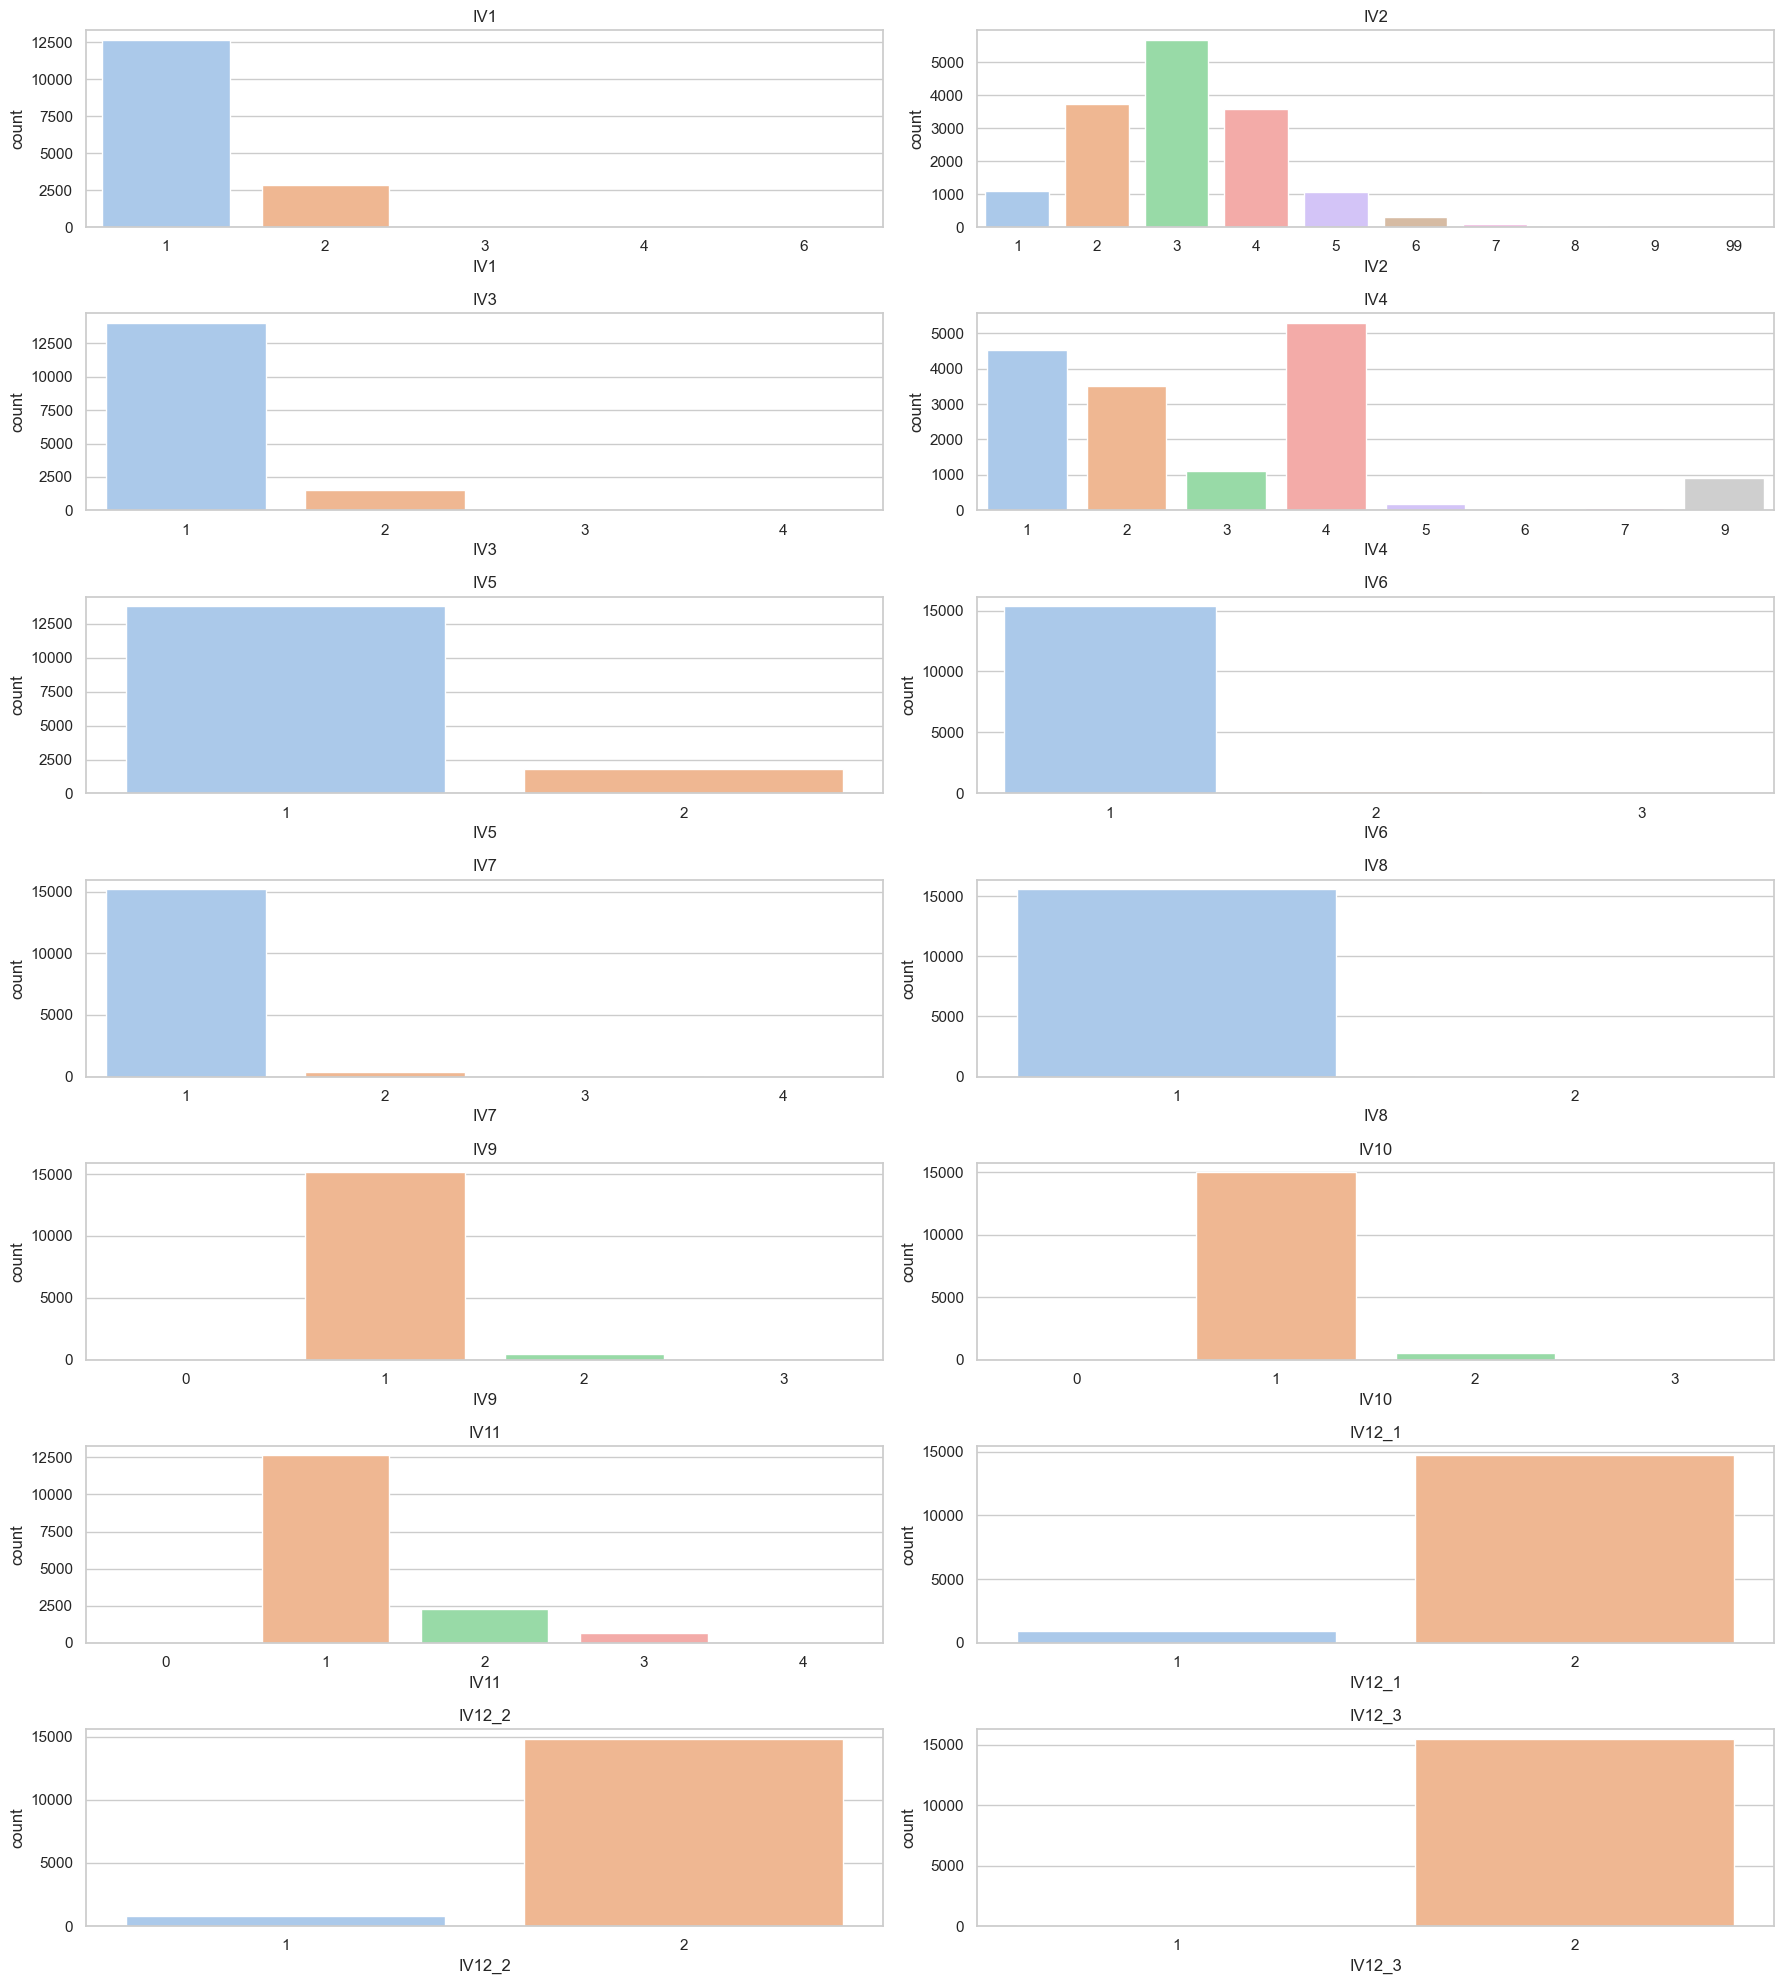

In [10]:
fig, axes = plt.subplots(infra.columns.size // 2, infra.columns.size // 7, figsize=(18,20))
for axis, col in zip(axes.ravel(), infra.columns):
    sns.countplot(infra, x=col, ax=axis)
    axis.title.set_text(col)
fig.tight_layout()

Only columns IV2 (number of rooms in the house), IV4 (material of the outer covering of the roof) and IV9 (if the bathroom is inside or outside of the house) have classes with some balance. I will keep those for the analysis.

In [26]:
cols_to_keep = ['CODUSU', 'NRO_HOGAR', 'REALIZADA', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA',
               'IV4', 'IV9']

Columns starting with II register characteristics of the house in terms of rooms.

In [12]:
rooms_col_filter = [col for col in eph_home if col.startswith('II')]

In [15]:
rooms = eph_home[rooms_col_filter].drop(['II7_ESP', 'II8_ESP'], axis=1) #IIn_ESP are used as "others" category
rooms.head()

,II1,II2,II3,II3_1,II4_1,II4_2,II4_3,II5,II5_1,II6,II6_1,II7,II8,II9
0,1,1,2,0,1,2,2,2,0,2,0,1,2,1
1,3,2,2,0,1,2,1,2,0,2,0,1,1,1
2,3,1,2,0,1,1,1,2,0,2,0,1,1,1
3,1,1,2,0,1,2,2,2,0,2,0,2,1,1
4,1,1,2,0,1,1,1,2,0,2,0,1,2,1


Columns 1 to 3 are used to register how many rooms are exclusive to the household, how many of those rooms are used to sleep and if any of those rooms are used exclusively as work areas. II7 is used to keep information about the possession regime of the house (if it's owned or rented, etc.).

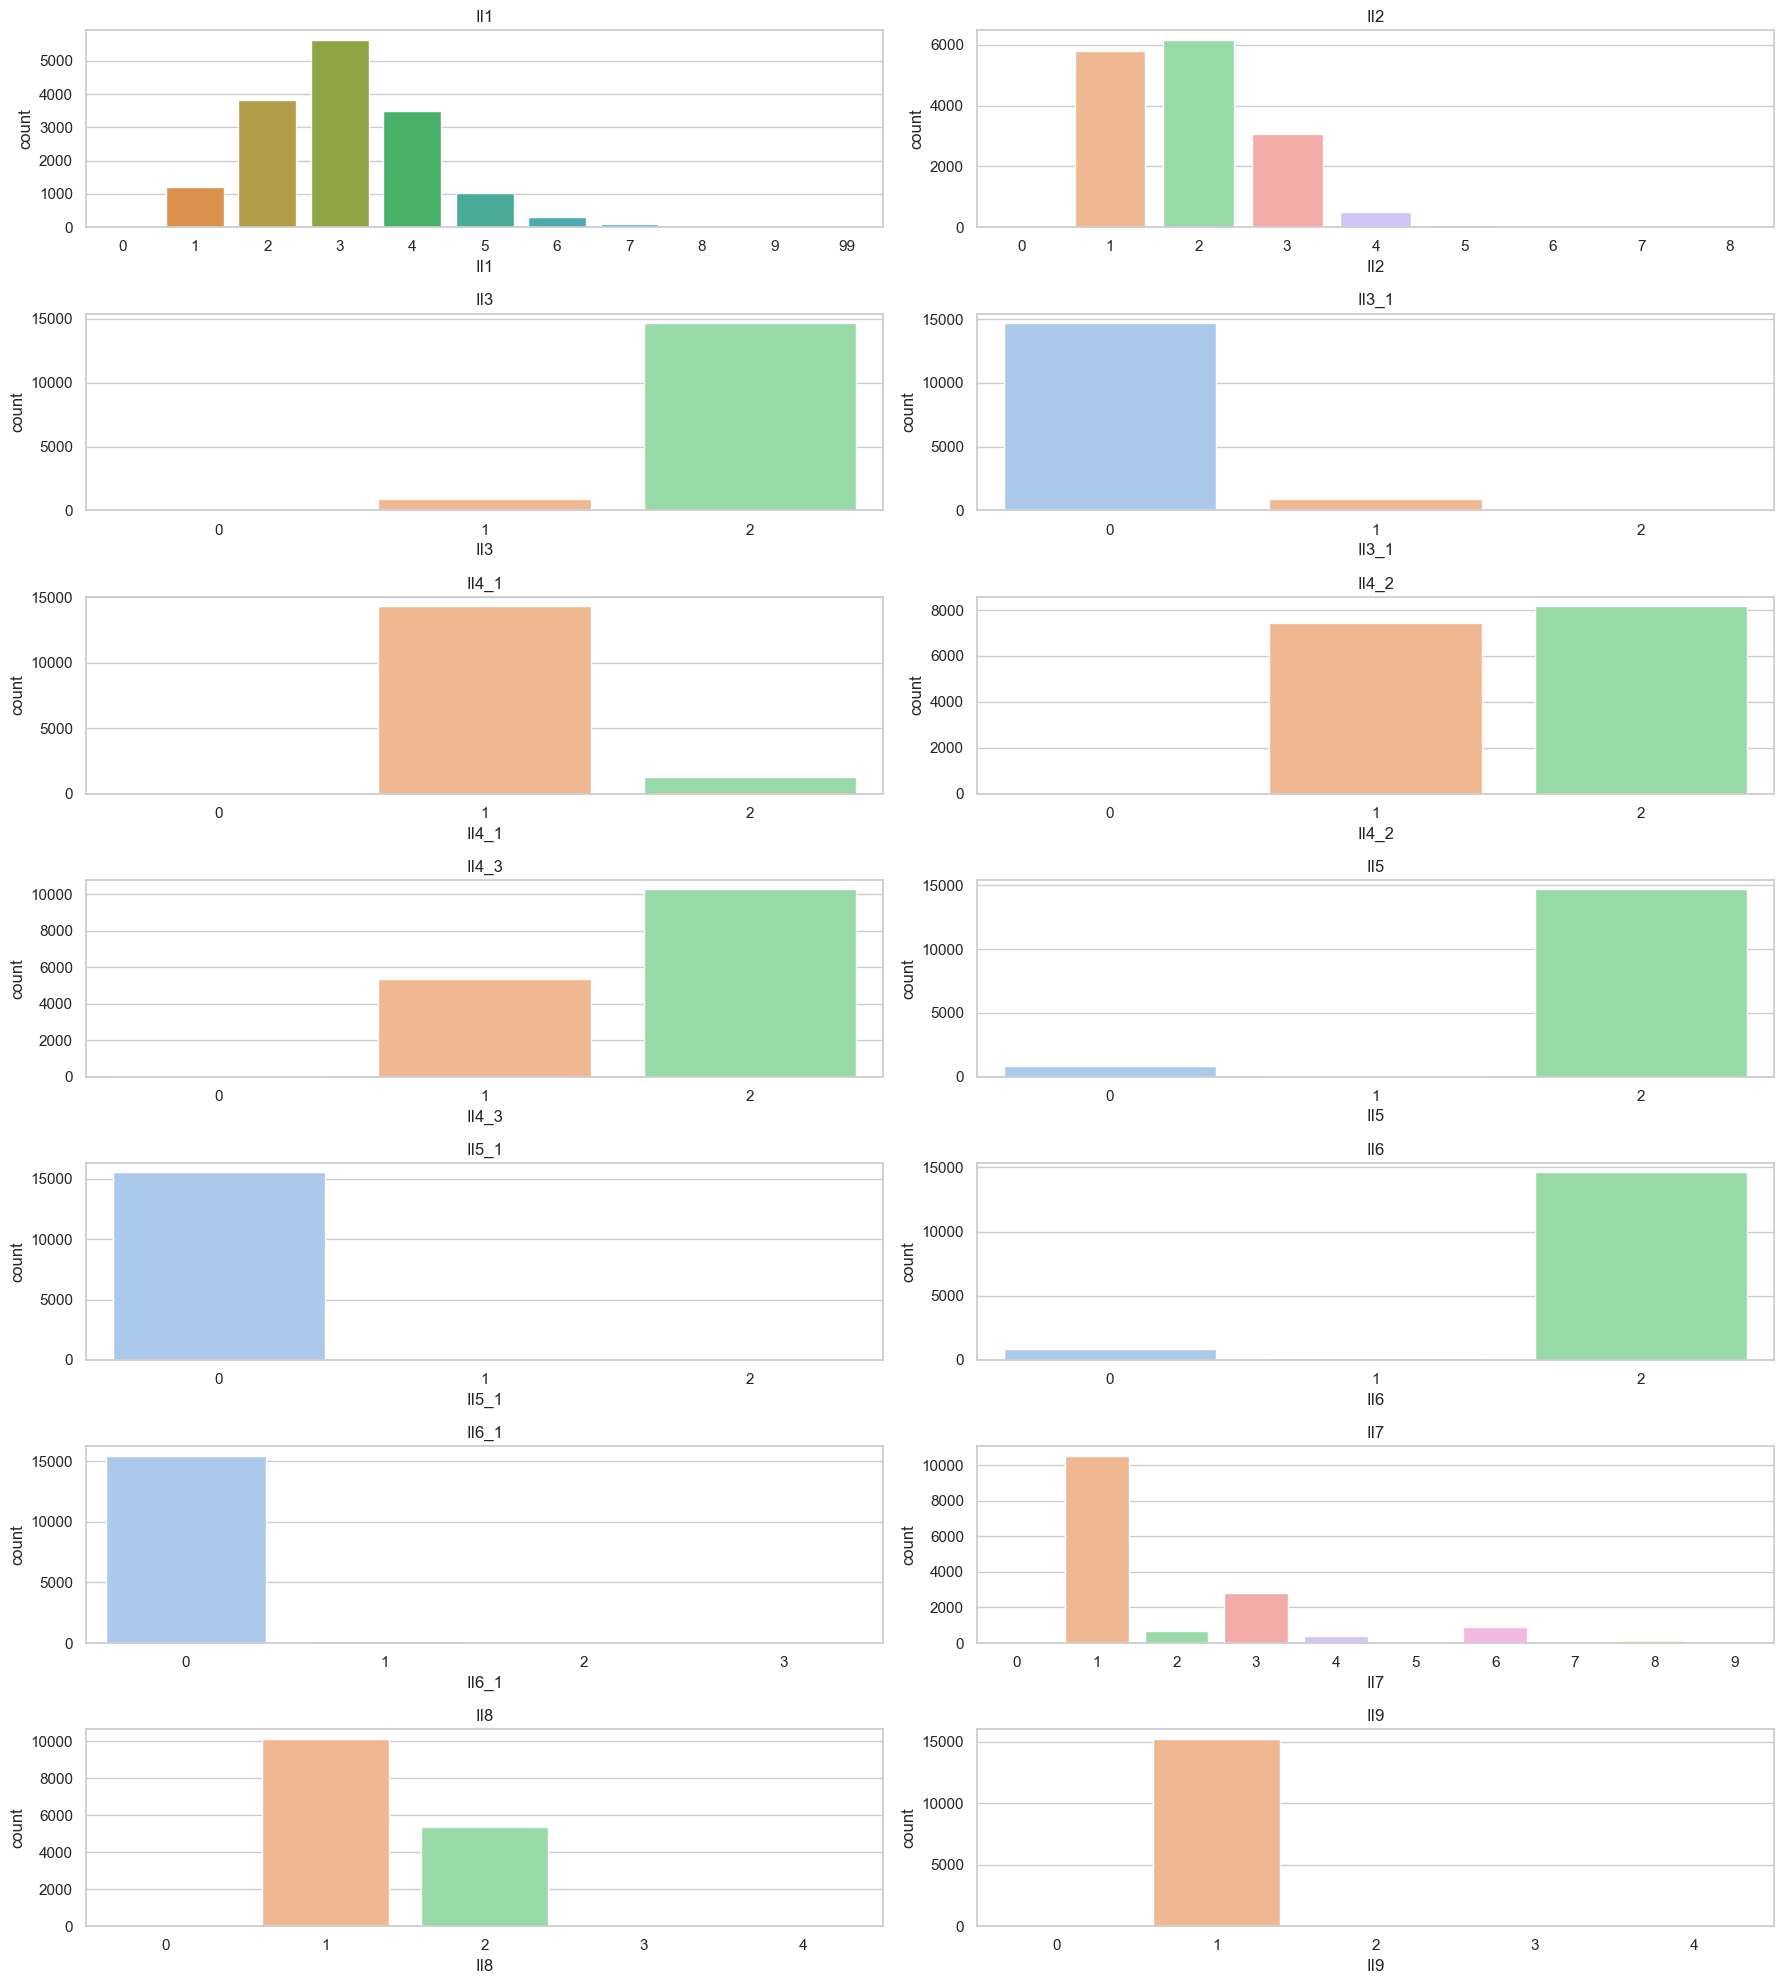

In [16]:
fig, axes = plt.subplots(rooms.columns.size // 2, rooms.columns.size // 7, figsize=(18,20))
for axis, col in zip(axes.ravel(), rooms.columns):
    sns.countplot(rooms, x=col, ax=axis)
    axis.title.set_text(col)
fig.tight_layout()

Keep the first two while, and add II7.

In [27]:
cols_to_keep.extend(['II1', 'II2', 'II7'])

In [28]:
cols_to_keep

['CODUSU',
 'NRO_HOGAR',
 'REALIZADA',
 'ANO4',
 'TRIMESTRE',
 'REGION',
 'MAS_500',
 'AGLOMERADO',
 'PONDERA',
 'IV4',
 'IV9',
 'II1',
 'II2',
 'II7']

Questions starting with V refer to household economic strategies. Lets plot them.

In [46]:
strat_col_filter = [col for col in eph_home if col.startswith('V')][0:22] # only the first 21

In [48]:
strategies = eph_home[strat_col_filter]
strategies.head()

,V1,V2,V21,V22,V3,V4,V5,V6,V7,V8,...,V11,V12,V13,V14,V15,V16,V17,V18,V19_A,V19_B
0,1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,1,2,2,2,2,2,2,2,2,2,...,2,2,1,2,2,1,2,2,2,2
2,2,1,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
3,1,2,2,2,2,2,2,2,2,2,...,2,2,2,1,2,1,1,2,2,2
4,1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2


In [49]:
strategies.columns.shape

(22,)

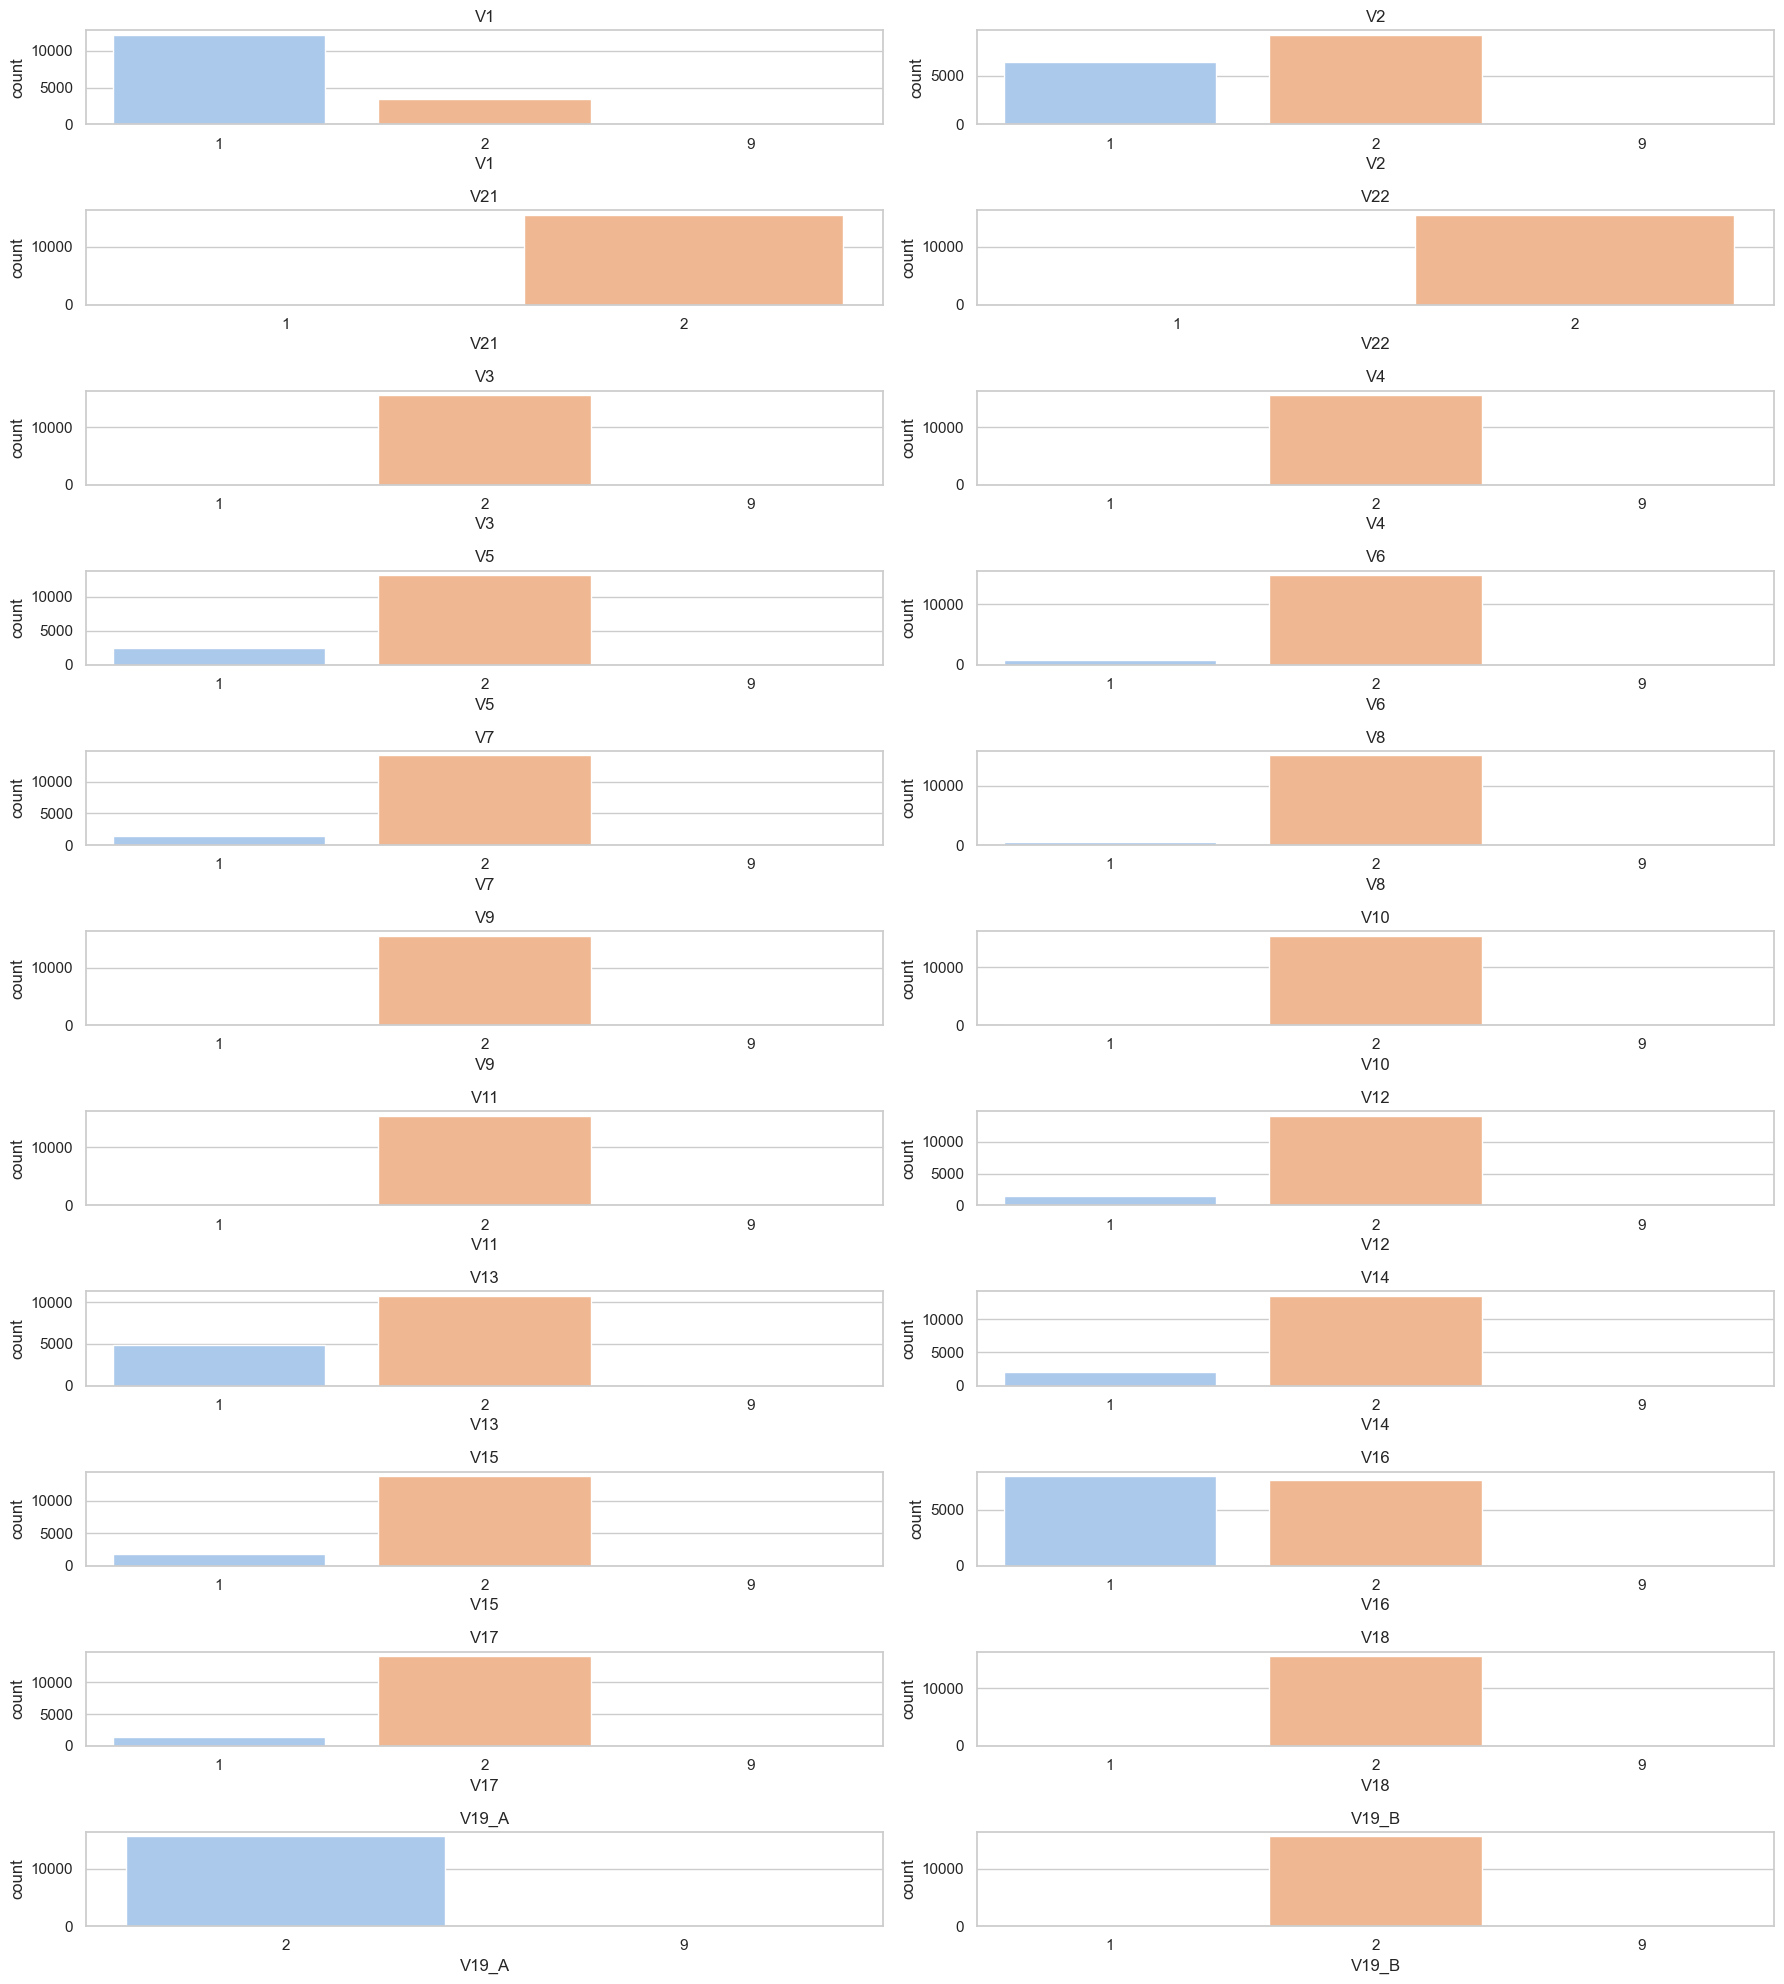

In [50]:
fig, axes = plt.subplots(strategies.columns.size // 2, strategies.columns.size // 11, figsize=(18,20))
for axis, col in zip(axes.ravel(), strategies.columns):
    sns.countplot(strategies, x=col, ax=axis)
    axis.title.set_text(col)
fig.tight_layout()

Won't keep any oh these. Let's continue by adding the summary cols and two referring to the household income: total income and decile.

In [51]:
cols_to_keep.extend(['IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'ITF', 'DECIFR'])
cols_to_keep

['CODUSU',
 'NRO_HOGAR',
 'REALIZADA',
 'ANO4',
 'TRIMESTRE',
 'REGION',
 'MAS_500',
 'AGLOMERADO',
 'PONDERA',
 'IV4',
 'IV9',
 'II1',
 'II2',
 'II7',
 'IX_Tot',
 'IX_Men10',
 'IX_Mayeq10',
 'ITF',
 'DECIFR']

In [77]:
cols_to_keep.extend('V11')

In [60]:
home = eph_home[cols_to_keep]

Now, let's continue with the individual database.

In [74]:
cols_to_keep_i = ['CODUSU', 'NRO_HOGAR', 'H15', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA']
ch_cols = [col for col in eph_people.columns if col.startswith('CH')][:14]
cols_to_keep_i.extend(ch_cols)

In [76]:
cols_to_keep_i.extend(['NIVEL_ED', 'CAT_OCUP', 'CAT_INAC'])

In [78]:
cols_to_keep_i.extend(['P47T', 'DECINDR', 'PONDII', 'V11_M'])

In [79]:
individual = eph_people[cols_to_keep_i]

In [91]:
data = individual.merge(home, on=['CODUSU', 'NRO_HOGAR', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO', 'PONDERA'], how='inner')

In [95]:
data.shape

(47085, 41)